In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [3]:
dir = './구독갱신예측/'

train = pd.read_csv(dir+'train.csv')
test = pd.read_csv(dir+'test.csv')
submission = pd.read_csv(dir+'sample_submission.csv')

train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [4]:
train.info(), train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

(None, (10000, 15))

In [5]:
from sklearn.model_selection import train_test_split

X = train.drop(['user_id', 'target'], axis=1)
y = train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
#수치형 변수 스케일링
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
num_features = X_train.select_dtypes(include=[np.number]).columns
num_features
X_train_ss = ss.fit_transform(X_train[num_features])
X_test_ss = ss.transform(X_test[num_features])

In [7]:
cat_features = X_train.select_dtypes(exclude=[np.number]).columns
# cat_features

mapping_difficulty = {'Low' : 0
					  ,'Medium' : 1
					  ,'High' : 2
					  }
X_train_label = X_train[cat_features[0]].map(mapping_difficulty).values.reshape(-1, 1)
X_test_label = X_test[cat_features[0]].map(mapping_difficulty).values.reshape(-1, 1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train[cat_features[1]].values.reshape(-1, 1)).toarray()
X_test_ohe = ohe.transform(X_test[cat_features[1]].values.reshape(-1, 1)).toarray()

In [8]:
# 결합
X_train_c = np.concatenate([X_train_ss, X_train_label, X_train_ohe], axis=1)
X_test_c = np.concatenate([X_test_ss, X_test_label, X_test_ohe], axis=1)

In [9]:
print(X_train_c.shape, X_test_c.shape)

(7500, 14) (2500, 14)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
rf = RandomForestClassifier()
rf.fit(X_train_c, y_train)

y_train_pred = rf.predict(X_train_c) 
y_test_pred = rf.predict(X_test_c)

print(f'train f1 : {f1_score(y_train, y_train_pred)} ')
print(f'test f1 : {f1_score(y_test, y_test_pred)} ')

train f1 : 1.0 
test f1 : 0.7303280874899973 


In [11]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(rf, X_train_c, y_train, n_repeats=30)

Text(0.5, 1.0, 'Feature Importances for RandomForest')

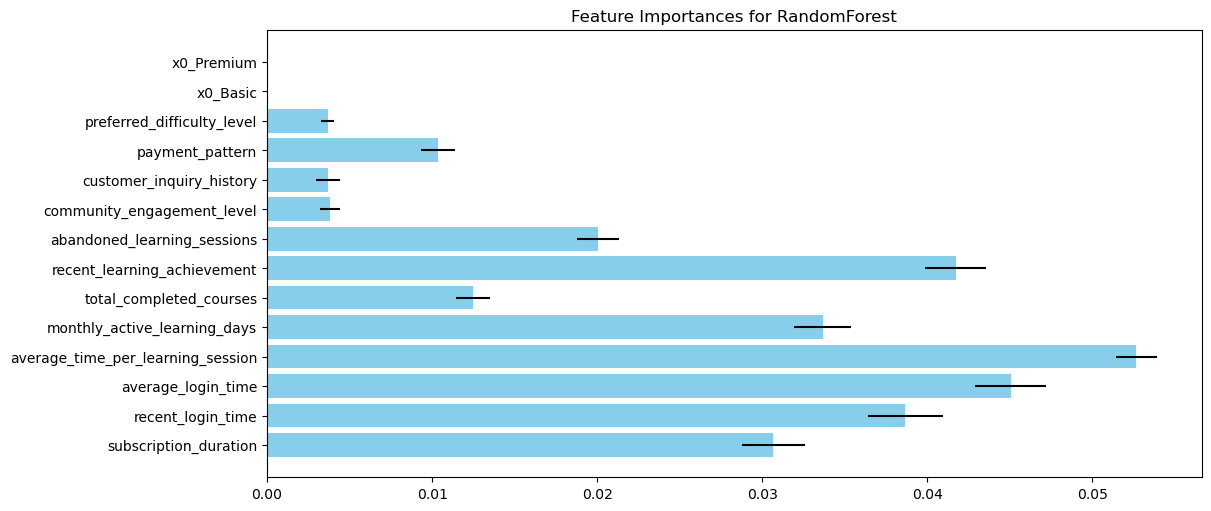

In [55]:
feature_names = list(num_features) + [cat_features[0]] + list(ohe.get_feature_names_out())
# feature_names

fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
ax.barh(feature_names, pi.importances_mean, xerr=pi.importances_std, color='skyblue')
ax.set_title('Feature Importances for RandomForest')